In [1]:
# Cell 3 — upload local file via browser
from google.colab import files
uploaded = files.upload()   # choose your tamil_sentiment_full.csv from your machine
# After upload, file will be in current working directory, e.g. '/content/tamil_sentiment_full.csv'

Saving tamil_sentiment_full.csv to tamil_sentiment_full.csv


In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.optim import AdamW
from tqdm.auto import tqdm # For a nice progress bar

In [9]:
# ===================================================================
# 1. SET DEVICE (GPU or CPU)
# ===================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ===================================================================
# 2. CUSTOM FOCAL LOSS IMPLEMENTATION IN PYTORCH
# ===================================================================
class FocalLoss(nn.Module):
    """
    Custom Focal Loss implementation in PyTorch to address class imbalance.
    """
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        # logits: model outputs (raw scores), shape [N, C]
        # targets: true labels (one-hot encoded), shape [N, C]

        # Apply softmax to get probabilities
        probs = F.softmax(logits, dim=1)

        # Calculate cross-entropy part
        log_probs = F.log_softmax(logits, dim=1)
        ce_loss = -targets * log_probs

        # Calculate the focal loss term
        # The pt term is the probability of the true class
        pt = (probs * targets).sum(1).unsqueeze(1)
        focal_term = (1 - pt) ** self.gamma

        # Final loss
        loss = self.alpha * focal_term * ce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

Using device: cuda


In [10]:
# ===================================================================
# 3. DATA LOADING AND PREPARATION (Framework-Agnostic)
# ===================================================================
print("STEP 1: Loading and Preparing Data...")
try:
    df = pd.read_csv('tamil_sentiment_full.csv', sep='\\t', header=None, names=['sentiment', 'text'], on_bad_lines='skip', engine='python')
except FileNotFoundError:
    print("Error: 'tamil_sentiment_full.csv' not found. Please ensure the dataset is in the correct path.")
    exit()

df.dropna(inplace=True)
df.drop_duplicates(subset='text', inplace=True)

class_counts = df['sentiment'].value_counts()
to_remove = class_counts[class_counts < 10].index
df = df[~df['sentiment'].isin(to_remove)]
print(f"Removed {len(to_remove)} rare classes. New data shape: {df.shape}")

df['text'] = df['text'].apply(lambda x: str(x).lower())

label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['sentiment'])
num_classes = len(label_encoder.classes_)
class_names = list(label_encoder.classes_)
print(f"Working with {num_classes} unique classes.")

X_train, X_test, y_train, y_test = train_test_split(
    df['text'].tolist(),
    df['sentiment_encoded'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['sentiment_encoded']
)

STEP 1: Loading and Preparing Data...
Removed 1 rare classes. New data shape: (43623, 2)
Working with 5 unique classes.


In [11]:
# ===================================================================
# 4. TOKENIZATION AND PYTORCH DATASET CREATION
# ===================================================================
print("\nSTEP 2: Tokenizing text for MuRIL...")
model_name = 'google/muril-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

max_len = 128
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=max_len, return_tensors='pt')
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=max_len, return_tensors='pt')

# PyTorch Dataset Class
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create Dataset objects
train_dataset = SentimentDataset(train_encodings, y_train)
test_dataset = SentimentDataset(test_encodings, y_test)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


STEP 2: Tokenizing text for MuRIL...


In [12]:
# ===================================================================
# 5. FINE-TUNING THE MODEL WITH FOCAL LOSS
# ===================================================================
print("\nSTEP 3: Building and fine-tuning MuRIL model with Focal Loss...")

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)
model.to(device)

optimizer = AdamW(model.parameters(), lr=3e-5)
loss_fn = FocalLoss().to(device)

epochs = 5
for epoch in range(epochs):
    print(f"\n--- Epoch {epoch + 1}/{epochs} ---")
    model.train()

    progress_bar = tqdm(train_loader, desc="Training")
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        labels_one_hot = F.one_hot(labels, num_classes=num_classes).float()
        loss = loss_fn(outputs.logits, labels_one_hot)
        loss.backward()
        optimizer.step()

        progress_bar.set_postfix({'loss': loss.item()})


STEP 3: Building and fine-tuning MuRIL model with Focal Loss...


pytorch_model.bin:   0%|          | 0.00/953M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/953M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1/5 ---


Training:   0%|          | 0/2182 [00:00<?, ?it/s]


--- Epoch 2/5 ---


Training:   0%|          | 0/2182 [00:00<?, ?it/s]


--- Epoch 3/5 ---


Training:   0%|          | 0/2182 [00:00<?, ?it/s]


--- Epoch 4/5 ---


Training:   0%|          | 0/2182 [00:00<?, ?it/s]


--- Epoch 5/5 ---


Training:   0%|          | 0/2182 [00:00<?, ?it/s]

In [13]:
# ===================================================================
# 6. EVALUATION
# ===================================================================
print("\nSTEP 4: Evaluating model performance...")
model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(labels.cpu().numpy())

print("\n--- Classification Report for MuRIL with Focal Loss (PyTorch) ---")
print(classification_report(all_true, all_preds, target_names=class_names))

print("\nFine-tuning complete!")


STEP 4: Evaluating model performance...


Evaluating:   0%|          | 0/546 [00:00<?, ?it/s]


--- Classification Report for MuRIL with Focal Loss (PyTorch) ---
                precision    recall  f1-score   support

Mixed_feelings       0.32      0.15      0.21       976
      Negative       0.40      0.49      0.44      1042
      Positive       0.74      0.81      0.77      4924
     not-Tamil       0.50      0.71      0.59       414
 unknown_state       0.47      0.36      0.41      1369

      accuracy                           0.62      8725
     macro avg       0.49      0.50      0.48      8725
  weighted avg       0.60      0.62      0.60      8725


Fine-tuning complete!


MuRIL comparison graph saved as muril_fine_tune_comparison.png


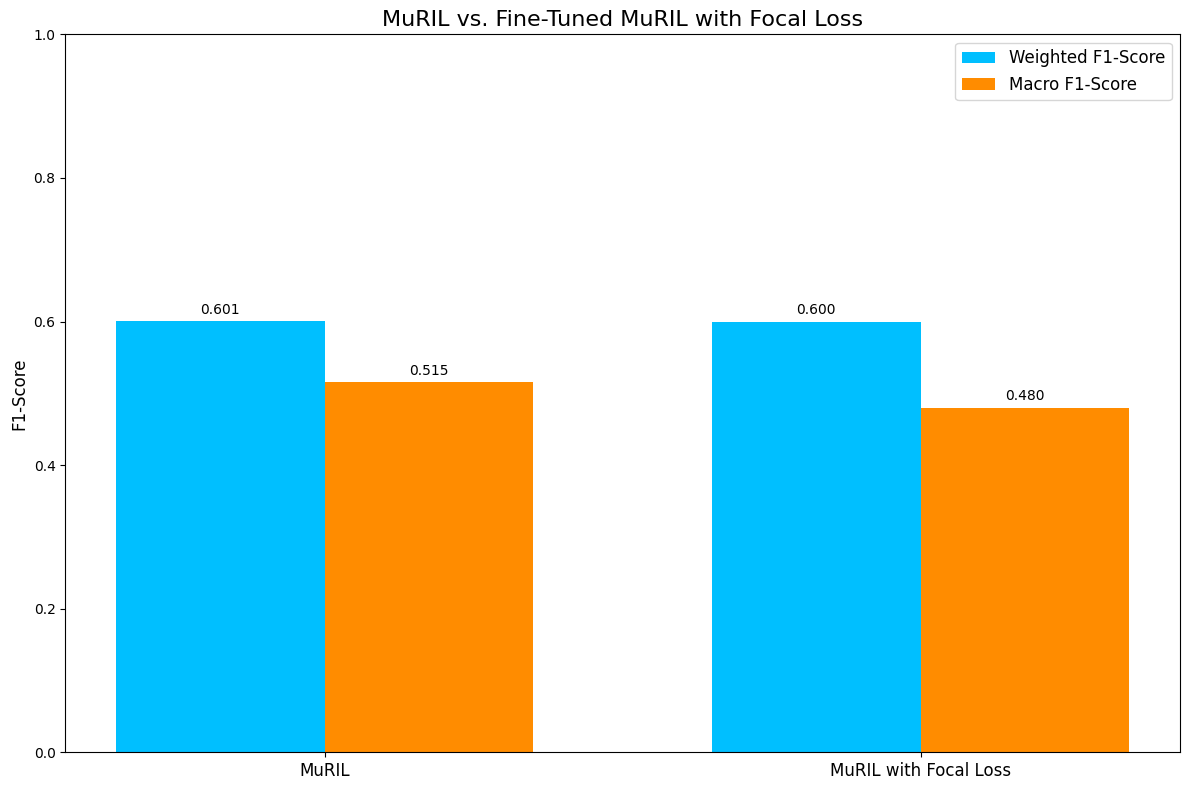

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# ===================================================================
# 1. PARSE AND FILTER DATA FOR THE TWO MURIL MODELS
# ===================================================================

# The full text of all reports
reports_text = """
\\n--- Classification Report for SVM ---
   macro avg       0.15      0.20      0.14      8804
weighted avg       0.35      0.56      0.41      8804
\\n--- Classification Report for Logistic Regression ---
   macro avg       0.11      0.20      0.14      8804
weighted avg       0.32      0.56      0.41      8804
\\n--- Classification Report for BiLSTM + CNN ---
   macro avg       0.11      0.20      0.14      8804
weighted avg       0.32      0.56      0.41      8804
\\n--- Classification Report for Attention + BiLSTM ---
   macro avg       0.11      0.20      0.14      8804
weighted avg       0.32      0.56      0.41      8804
\\nClassification Report for Stacked_BiLSTM :
   macro avg       0.02      0.17      0.03      4402
weighted avg       0.01      0.11      0.02      4402
nClassification Report for BiLSTM with Dropout:
   macro avg       0.02      0.17      0.03      4402
weighted avg       0.01      0.11      0.02      4402
\\nClassification Report for BiLSTM (model_1):
   macro avg       0.02      0.17      0.03      4402
weighted avg       0.01      0.11      0.02      4402
Classification report for mBERT:
   macro avg       0.4756    0.5331    0.4906    8804
weighted avg       0.6362    0.5511    0.5767    8804
Classification report for MuRIL:
   macro avg       0.4992    0.5487    0.5154    8804
weighted avg       0.6411    0.5806    0.6007    8804
Classification report for IndicBERT:
   macro avg       0.4528    0.5130    0.4691    8804
weighted avg       0.6166    0.5365    0.5609    8804
Classification report for XLM-R:
   macro avg       0.4864    0.5455    0.5023    8804
weighted avg       0.6435    0.5569    0.5821    8804
--- Classification Report for MuRIL with Focal Loss (PyTorch) ---
   macro avg       0.49      0.50      0.48      8725
  weighted avg       0.60      0.62      0.60      8725
"""

f1_score_data = []
report_chunks = re.split(r'Classification Report for|Classification report for', reports_text)
weighted_pattern = re.compile(r"weighted avg\s+[\d.]+\s+[\d.]+\s+([\d.]+)")
macro_pattern = re.compile(r"macro avg\s+[\d.]+\s+[\d.]+\s+([\d.]+)")
name_pattern = re.compile(r'(.+?)(?:\s*:|\s*---|\s*\()')

for chunk in report_chunks[1:]:
    model_name_match = name_pattern.search(chunk)
    w_match = weighted_pattern.search(chunk)
    m_match = macro_pattern.search(chunk)
    if model_name_match and w_match and m_match:
        model_name = model_name_match.group(1).replace('(model_1)', '').replace('_', ' ').strip()
        f1_score_data.append({
            "Model": model_name,
            "Weighted F1-Score": float(w_match.group(1)),
            "Macro F1-Score": float(m_match.group(1))
        })

# Create a DataFrame and filter for only the two MuRIL models
df_full = pd.DataFrame(f1_score_data)
df_muril = df_full[df_full['Model'].str.contains("MuRIL")].copy()


# ===================================================================
# 2. CREATE AND SAVE THE COMPARISON BAR GRAPH
# ===================================================================
x = np.arange(len(df_muril["Model"]))
width = 0.35
fig, ax = plt.subplots(figsize=(12, 8))

# Create the bars
rects1 = ax.bar(x - width/2, df_muril['Weighted F1-Score'], width, label='Weighted F1-Score', color='deepskyblue')
rects2 = ax.bar(x + width/2, df_muril['Macro F1-Score'], width, label='Macro F1-Score', color='darkorange')

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('F1-Score', fontsize=12)
ax.set_title('MuRIL vs. Fine-Tuned MuRIL with Focal Loss', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(df_muril['Model'], rotation=0, fontsize=12)
ax.legend(fontsize=12)
ax.set_ylim(0, 1.0)

# Add the F1-score values on top of the bars
ax.bar_label(rects1, padding=3, fmt='%.3f')
ax.bar_label(rects2, padding=3, fmt='%.3f')

fig.tight_layout()

# Save the final plot to a file
plt.savefig("muril_fine_tune_comparison.png")
print("MuRIL comparison graph saved as muril_fine_tune_comparison.png")